In [1]:
import numpy as np
import pandas as pd
import os

### 匯率資料
1. 前述的資料為Investing.com的匯率日資料
2. 加強版的部分，之後可不可以串接其他的網站，將匯率的資料細分到奈秒 (ns) 等級，可以進行更精確 & 短時間的交易，參見Google drive


In [2]:
os.chdir("./data")
os.listdir()

['EUR_USD.csv',
 'GBP_USD.csv',
 'output',
 'TechnicalAnalysis.csv',
 'TWD_processed.csv',
 'USD_CNY.csv',
 'USD_JPY.csv',
 'USD_TWD.csv']

In [3]:
df = pd.read_csv('USD_TWD.csv')
df.head()
USD = "USD" #之後要處理tag
common_columns = ["Price", "Open", "High", "Low"]

In [4]:
###將台幣做倒數
def TWD_inderect(df, columns):
    df[columns]= 1.0 / df[columns]
    return df

df = TWD_inderect(df, common_columns)

### 必須重新定義pct_change()，因為有蠻多值變成0的，不知道為啥
發現有 5.3% 的價格沒有變動(change = 0%)，可以思考為啥？

In [5]:
# 計算日資料的報酬率
def get_percentage(df):
    x = (df["Price"].iloc[1:].reset_index(drop=True) / df["Price"].iloc[0:-1]) -1
    x = pd.concat([pd.Series([None]), x])
    df["Change %"]= x.tolist()
    return df

df = get_percentage(df)
display(df)

,Date,Price,Open,High,Low,Change %
0,2000/1/3,0.031883,0.031883,0.031852,0.031903,NaN
1,2000/1/4,0.032760,0.032180,0.032118,0.032760,0.027518
2,2000/1/5,0.032547,0.032760,0.032441,0.032760,-0.006509
3,2000/1/6,0.032489,0.032489,0.031526,0.032499,-0.001787
4,2000/1/7,0.032494,0.032347,0.032305,0.032494,0.000162
...,...,...,...,...,...,...
5692,2021/10/25,0.035878,0.035904,0.035817,0.035926,-0.000179
5693,2021/10/26,0.035987,0.035872,0.035837,0.036054,0.003023
5694,2021/10/27,0.035973,0.035966,0.035862,0.036056,-0.000396
5695,2021/10/28,0.035985,0.035953,0.035871,0.036063,0.000360


### 前面單純處理一段時間的資料的數值，不用判斷是哪一個currency。

之後要丟入所有資料前再根據currency (class variable) concat 新增相對應時間的rows

In [6]:
def rename_currency_data(df, currency):
    df = df.rename(columns={"Price": "Price_"+currency, "Open": "Open_"+currency, "High": "High_"+currency, "Low":"Low_"+currency, "Change %": currency+"_Change %"})
    return df

df = rename_currency_data(df, USD)

### 思考：以上做法為已知Excel data, 那如何處理動態的pipeline ??
Ans: 串接API，例如yahoo.finance or OANDA

1. 轉換成台幣為主的直接匯率
2. rename
3. merge (by Datetime)

### 人民幣
轉換為台幣的間接匯率

多少外幣 = 1 台幣

TWD/USD * USD/CNY = TWD/CNY，其他貨幣也是如此，除了英鎊要用除的

TWD/USD 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5697 entries, 0 to 5696
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5697 non-null   object 
 1   Price_USD     5697 non-null   float64
 2   Open_USD      5697 non-null   float64
 3   High_USD      5697 non-null   float64
 4   Low_USD       5697 non-null   float64
 5   USD_Change %  5696 non-null   float64
dtypes: float64(5), object(1)
memory usage: 267.2+ KB


In [8]:
#之後用 for 迴圈去控制規則
currency_list=["CNY", "JPY", "EUR", "GBP"] 

### 下一個Cell算法會發現每個市場的資料長短都不同，我認為市場會是平滑連續的，所以採用插值法的方式補值應該就可以。

先Merge, 補null, 再相乘

In [9]:
df3 = df
for (index, currency) in enumerate(currency_list):
    if currency in ["EUR", "GBP"]:
#     if currency in ["EUR"]:
        df2 = pd.read_csv(currency+"_USD.csv")
        df3 = df3.merge(df2, how='left',on='Date')
        #內插法補 null 值
        df3 = df3.interpolate(method='linear')
        for column in common_columns:
            df3[column] = df3[column+"_USD"]/df3[column]
        df3 = get_percentage(df3)
        df3 = rename_currency_data(df3, currency)
    elif currency in ["CNY", "JPY"]:
        df2 = pd.read_csv("USD_"+currency+".csv")
        df3 = df3.merge(df2, how='left',on='Date')
        #內插法補 null 值
        df3 = df3.interpolate(method='linear')
        for column in common_columns:
            df3[column] = df3[column+"_USD"] * df3[column]
        df3 = get_percentage(df3)
        df3 = rename_currency_data(df3, currency)
df3.info()
# print(df3.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5697 entries, 0 to 5696
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5697 non-null   object 
 1   Price_USD     5697 non-null   float64
 2   Open_USD      5697 non-null   float64
 3   High_USD      5697 non-null   float64
 4   Low_USD       5697 non-null   float64
 5   USD_Change %  5696 non-null   float64
 6   Price_CNY     5697 non-null   float64
 7   Open_CNY      5697 non-null   float64
 8   High_CNY      5697 non-null   float64
 9   Low_CNY       5697 non-null   float64
 10  CNY_Change %  5696 non-null   float64
 11  Price_JPY     5697 non-null   float64
 12  Open_JPY      5697 non-null   float64
 13  High_JPY      5697 non-null   float64
 14  Low_JPY       5697 non-null   float64
 15  JPY_Change %  5696 non-null   float64
 16  Price_EUR     5697 non-null   float64
 17  Open_EUR      5697 non-null   float64
 18  High_EUR      5697 non-null 

### 計算技術分析的指標
1. RSI
2. MACD
3. CCI
4. Moving average
5. S1~S3 R1~R3
6. 類別（漲跌）

技術指標參考：https://www.books.com.tw/products/E050097108

ps: 還有筆記在 Google drive
1. RSI在2001 11月左右 RSI有許多缺值，因為匯率完全沒有變動所以 0/0 會顯現出inf，有可能是當初補值造成的(?)，我直接fillna(0)

In [10]:
### RSI，常用以 7 天與 14 天為例，常以20 & 80為區分買賣壓界線
### 為了避免分母為零，先篩選up+down的值不為零
def calculate_RSI(df, symbols, window):
    columns = list(map(lambda x: "Price_"+x, symbols))
    for (index, column) in enumerate(columns):
        symbol = symbols[index]
        temp_array = df[column].values
        #計算匯率數值之間的差距
        difference = list(map(lambda x, y: y-x, temp_array[:-1], temp_array[1:]))
        difference.insert(0,None)
        rsi_list = [None]*6
        for index in range(len(difference))[window-1:]:
            up = 0.0
            down = 0.0
            for value in difference[index-window+2:index+1]:
                if value > 0.0:
                    up += value
                else:
                    value *= -1
                    down +=value
            rsi = 0
            if (up+down) != 0:
                rsi = (up/(up+down))*100.0
            rsi_list.append(rsi)
        df3["RSI_"+str(window)+"_"+symbol] = rsi_list
        df3["RSI_"+str(window)+"_"+symbol]=df3["RSI_"+str(window)+"_"+symbol].fillna(0)

        

symbols = ["USD", "CNY", "GBP", "JPY", "EUR"]
calculate_RSI(df3, symbols , 7)
# calculate_RSI(df3,symbols, 14)
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5697 entries, 0 to 5696
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5697 non-null   object 
 1   Price_USD     5697 non-null   float64
 2   Open_USD      5697 non-null   float64
 3   High_USD      5697 non-null   float64
 4   Low_USD       5697 non-null   float64
 5   USD_Change %  5696 non-null   float64
 6   Price_CNY     5697 non-null   float64
 7   Open_CNY      5697 non-null   float64
 8   High_CNY      5697 non-null   float64
 9   Low_CNY       5697 non-null   float64
 10  CNY_Change %  5696 non-null   float64
 11  Price_JPY     5697 non-null   float64
 12  Open_JPY      5697 non-null   float64
 13  High_JPY      5697 non-null   float64
 14  Low_JPY       5697 non-null   float64
 15  JPY_Change %  5696 non-null   float64
 16  Price_EUR     5697 non-null   float64
 17  Open_EUR      5697 non-null   float64
 18  High_EUR      5697 non-null 

In [11]:
for i in range(10)[3:]:
    print(i)

3
4
5
6
7
8
9


In [12]:
def moving_average(df, symbols, window):
    columns = list(map(lambda x: "Price_"+x, symbols))
    for (index, column) in enumerate(columns):
        symbol = symbols[index]
        temp_array = df[column].values
        moving_average = [None] * (window-1)
        for index in range(len(temp_array))[window-1:]:
            total = 0.0
            for value in temp_array[index-window+1:index+1]:
                total += value
            average = total/window
            moving_average.append(average)
        df3["MA_"+str(window)+"_"+symbol] = moving_average
        df3["MA_"+str(window)+"_"+symbol] = df3["MA_"+str(window)+"_"+symbol].fillna(0)
moving_average(df3, symbols, 5)
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5697 entries, 0 to 5696
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5697 non-null   object 
 1   Price_USD     5697 non-null   float64
 2   Open_USD      5697 non-null   float64
 3   High_USD      5697 non-null   float64
 4   Low_USD       5697 non-null   float64
 5   USD_Change %  5696 non-null   float64
 6   Price_CNY     5697 non-null   float64
 7   Open_CNY      5697 non-null   float64
 8   High_CNY      5697 non-null   float64
 9   Low_CNY       5697 non-null   float64
 10  CNY_Change %  5696 non-null   float64
 11  Price_JPY     5697 non-null   float64
 12  Open_JPY      5697 non-null   float64
 13  High_JPY      5697 non-null   float64
 14  Low_JPY       5697 non-null   float64
 15  JPY_Change %  5696 non-null   float64
 16  Price_EUR     5697 non-null   float64
 17  Open_EUR      5697 non-null   float64
 18  High_EUR      5697 non-null 

In [13]:
### KD (K & D & RSV公式)
### KD通常以9為週期
def calculate_KD(df, symbols, window):
    columns = list(map(lambda x: ["Price_"+x, "High_"+x, "Low_"+x], symbols))
    for (index, column) in enumerate(columns):
        symbol = symbols[index]
        temp_array = df[column].values
        k_list = [0]*(window-1)
        d_list = [0]*(window-1)
        for index in range(len(temp_array[:,0]))[window-1:]:
            highest = max(temp_array[index-window+1:index+1,1])
            lowest = min(temp_array[index-window+1:index+1,2])
            current_price = temp_array[index,0]
            rsv = 0
            if (highest-lowest) != 0:
                rsv = ((current_price-lowest) / (highest - lowest)) * 100
            k_today = 2/3 * k_list[index-1] + 1/3 * rsv
            d_today = 2/3 * d_list[index-1] + 1/3 * k_today
            k_list.append(k_today)
            d_list.append(d_today)
        K_vs_D = list(map(lambda x,y: 1 if y>x else 0 , d_list, k_list))
        df3["K_"+str(window)+"_"+symbol] = k_list
        df3["D_"+str(window)+"_"+symbol] = d_list
        df3["K>D_"+str(window)+"_"+symbol] = K_vs_D
        
calculate_KD(df3, symbols, 9)
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5697 entries, 0 to 5696
Data columns (total 51 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5697 non-null   object 
 1   Price_USD     5697 non-null   float64
 2   Open_USD      5697 non-null   float64
 3   High_USD      5697 non-null   float64
 4   Low_USD       5697 non-null   float64
 5   USD_Change %  5696 non-null   float64
 6   Price_CNY     5697 non-null   float64
 7   Open_CNY      5697 non-null   float64
 8   High_CNY      5697 non-null   float64
 9   Low_CNY       5697 non-null   float64
 10  CNY_Change %  5696 non-null   float64
 11  Price_JPY     5697 non-null   float64
 12  Open_JPY      5697 non-null   float64
 13  High_JPY      5697 non-null   float64
 14  Low_JPY       5697 non-null   float64
 15  JPY_Change %  5696 non-null   float64
 16  Price_EUR     5697 non-null   float64
 17  Open_EUR      5697 non-null   float64
 18  High_EUR      5697 non-null 

In [14]:
# MACD 是死亡交叉還啥的繼續分析使用到的工具
def calculate_MACD(df, symbols):
    columns = list(map(lambda x: "Price_"+x, symbols))
    for (index, column) in enumerate(columns):
        symbol = symbols[index]
        temp_df = df[column]
        k = temp_df.ewm(span=12, adjust=False, min_periods=12).mean()
        # Get the 12-day EMA of the closing price
        d = temp_df.ewm(span=26, adjust=False, min_periods=26).mean()
        # Subtract the 26-day EMA from the 12-Day EMA to get the MACD
        macd = k - d
        # Get the 9-Day EMA of the MACD for the Trigger line
        macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()
        # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
        macd_h = macd_s - macd
        # Add all of our new values for the MACD to the dataframe
        df3['macd_'+symbol] = temp_df.index.map(macd).fillna(0)
        df3['macd_h_'+symbol] = temp_df.index.map(macd_h).fillna(0)
        df3['macd_s_'+symbol] = temp_df.index.map(macd_s).fillna(0)
calculate_MACD(df3, symbols)
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5697 entries, 0 to 5696
Data columns (total 66 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5697 non-null   object 
 1   Price_USD     5697 non-null   float64
 2   Open_USD      5697 non-null   float64
 3   High_USD      5697 non-null   float64
 4   Low_USD       5697 non-null   float64
 5   USD_Change %  5696 non-null   float64
 6   Price_CNY     5697 non-null   float64
 7   Open_CNY      5697 non-null   float64
 8   High_CNY      5697 non-null   float64
 9   Low_CNY       5697 non-null   float64
 10  CNY_Change %  5696 non-null   float64
 11  Price_JPY     5697 non-null   float64
 12  Open_JPY      5697 non-null   float64
 13  High_JPY      5697 non-null   float64
 14  Low_JPY       5697 non-null   float64
 15  JPY_Change %  5696 non-null   float64
 16  Price_EUR     5697 non-null   float64
 17  Open_EUR      5697 non-null   float64
 18  High_EUR      5697 non-null 

In [15]:
### 乖離值

In [16]:
### 布林通道

### 寫一個投資策略
1. time series
2. 取各種技術指標
##### Google 搜尋：投資策略Python or Investing strategy with python 

In [17]:
df3["Date"] = pd.to_datetime(df3["Date"])
df3 = df3.set_index("Date")
df3.head()

,Price_USD,Open_USD,High_USD,Low_USD,USD_Change %,Price_CNY,Open_CNY,High_CNY,Low_CNY,CNY_Change %,...,macd_s_CNY,macd_GBP,macd_h_GBP,macd_s_GBP,macd_JPY,macd_h_JPY,macd_s_JPY,macd_EUR,macd_h_EUR,macd_s_EUR
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.031883,0.031883,0.031852,0.031903,NaN,0.263982,0.263982,0.263730,0.264151,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-04,0.032760,0.032180,0.032118,0.032760,0.027518,0.271250,0.266449,0.265935,0.271250,0.027531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-05,0.032547,0.032760,0.032441,0.032760,-0.006509,0.269481,0.271247,0.268607,0.271247,-0.006521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-06,0.032489,0.032489,0.031526,0.032499,-0.001787,0.268996,0.268996,0.261025,0.269084,-0.001799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-07,0.032494,0.032347,0.032305,0.032494,0.000162,0.269030,0.267812,0.267466,0.269030,0.000126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
temp_df_1 = df3.loc["2013":"2016"]
temp_df = df3.loc["2017":"2021"]
temp_df_1.tail()

,Price_USD,Open_USD,High_USD,Low_USD,USD_Change %,Price_CNY,Open_CNY,High_CNY,Low_CNY,CNY_Change %,...,macd_s_CNY,macd_GBP,macd_h_GBP,macd_s_GBP,macd_JPY,macd_h_JPY,macd_s_JPY,macd_EUR,macd_h_EUR,macd_s_EUR
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-26,0.031036,0.031029,0.031014,0.031185,-0.001428,0.215664,0.215462,0.215569,0.216543,-0.001068,...,0.000424,0.000026,-0.000054,-0.000028,0.053324,0.009270,0.062595,0.000156,0.000024,0.000180
2016-12-27,0.030978,0.031002,0.030914,0.031114,-0.001859,0.215374,0.215507,0.214981,0.216129,-0.001342,...,0.000359,0.000030,-0.000047,-0.000016,0.049043,0.010842,0.059884,0.000133,0.000038,0.000171
2016-12-28,0.030840,0.030983,0.030807,0.031041,-0.004441,0.214628,0.215377,0.214479,0.215785,-0.003467,...,0.000279,0.000032,-0.000039,-0.000007,0.043423,0.013169,0.056592,0.000113,0.000046,0.000159
2016-12-29,0.030965,0.030937,0.030872,0.031008,0.004025,0.215365,0.215020,0.214791,0.215495,0.003434,...,0.000205,0.000035,-0.000033,0.000002,0.037956,0.014908,0.052865,0.000087,0.000058,0.000145
2016-12-30,0.030813,0.030989,0.030801,0.031147,-0.004899,0.213995,0.215547,0.214240,0.216221,-0.006359,...,0.000116,0.000015,-0.000011,0.000004,0.032667,0.016158,0.048825,0.000049,0.000076,0.000126


In [19]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1263 entries, 2017-01-02 to 2021-10-29
Data columns (total 65 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price_USD     1263 non-null   float64
 1   Open_USD      1263 non-null   float64
 2   High_USD      1263 non-null   float64
 3   Low_USD       1263 non-null   float64
 4   USD_Change %  1263 non-null   float64
 5   Price_CNY     1263 non-null   float64
 6   Open_CNY      1263 non-null   float64
 7   High_CNY      1263 non-null   float64
 8   Low_CNY       1263 non-null   float64
 9   CNY_Change %  1263 non-null   float64
 10  Price_JPY     1263 non-null   float64
 11  Open_JPY      1263 non-null   float64
 12  High_JPY      1263 non-null   float64
 13  Low_JPY       1263 non-null   float64
 14  JPY_Change %  1263 non-null   float64
 15  Price_EUR     1263 non-null   float64
 16  Open_EUR      1263 non-null   float64
 17  High_EUR      1263 non-null   float64
 18  Low_EUR   

### 回測

指標：
1. RSI > 80 跌，賣 ; RSI <20 買 ：表示市場強度（反應投資人的心理）
2. KD  K>D 做多、K<D 做空
3. Moving average: 5日線 vs 現價，若現價從上穿過5日線，賣 : 由下穿到上 -> 買 
4. MACD 快線-慢線，買進訊號為負轉正

In [20]:
# RSI_7_USD
def strategy_for_rsi(df, symbol):
    window = 7
    strength_rsi =[]
    rsi_list = df["RSI_7_"+symbol].tolist()
    for rsi in rsi_list:
        strength = 0
        if rsi >=80:
            strength = 2
        elif rsi >=70:
            strength = 1
        elif rsi <=20:
            strength = -2
        elif rsi <=30:
            strength = -1
        strength_rsi.append(strength)
    return strength_rsi

rsi = strategy_for_rsi(temp_df, "USD")
rsi_1 = strategy_for_rsi(temp_df_1, "USD")
#外面存一個currency_strength相關的變數，還有一個 trend 的變數

In [21]:
# K>D_9_USD
# K_9_USD
def strategy_for_kd(df, symbol):
    strength_kd = []
    k_list = df["K_9_"+symbol].tolist()
    d_list = df["D_9_"+symbol].tolist()
    kd_list = list(map(lambda x,y: 1 if y>x else -1 , d_list, k_list))
    for index, k_vs_d in enumerate(kd_list):
        strength = 0
        if index ==0:
            strength_kd.append(k_vs_d)
        else:
            if (k_vs_d * kd_list[index-1] == -1) and k_vs_d == 1:
                strength =2
            elif (k_vs_d * kd_list[index-1] == -1) and k_vs_d == -1:
                strength =-2
            else:
                strength = k_vs_d
            strength_kd.append(strength)
    return strength_kd

kd = strategy_for_kd(temp_df, "USD")
kd_1 = strategy_for_kd(temp_df_1, "USD")

In [22]:
# MA_5_USD
def strategy_for_ma(df, symbol):
    price = df["Price_"+symbol].tolist()
    ma = df["MA_5_"+symbol].tolist()
    price_ma_list = list(map(lambda x,y: 1 if y>x else -1 , ma, price))
    trend_ma = []
    for index, price_vs_ma in enumerate(price_ma_list):
        trend = 0
        if index ==0:
            trend_ma.append(price_vs_ma)
        else:
            if (price_vs_ma * price_ma_list[index-1] == -1) and price_vs_ma == 1:
                trend = 2
            elif (price_vs_ma * price_ma_list[index-1] == -1) and price_vs_ma == -1:
                trend = -2
            else:
                trend = price_vs_ma
            trend_ma.append(trend)
    return trend_ma
    
ma = strategy_for_ma(temp_df, "USD")
ma_1 = strategy_for_ma(temp_df_1, "USD")

In [23]:
# macd_USD
# macd_h_USD
# macd_s_USD

def strategy_for_macd(df, symbol):
    macd = df["macd_h_"+symbol].tolist()
    macd_signals = list(map(lambda x: 1 if x>=0 else -1 , macd))
    trend_macd = []
    for index, macd_signal in enumerate(macd_signals):
        trend = 0
        if index ==0:
            trend_macd.append(macd_signal)
        else:
            if (macd_signal * macd_signals[index-1] == -1) and macd_signal == 1:
                trend = 2
            elif (macd_signal * macd_signals[index-1] == -1) and macd_signal == -1:
                trend = -2
            else:
                trend = macd_signal
            trend_macd.append(trend)
    return trend_macd
    
macd = strategy_for_macd(temp_df, "USD")
macd_1 = strategy_for_macd(temp_df_1, "USD")

In [24]:
strength = list(map(lambda x,y: x+y, rsi,kd))
trend = list(map(lambda x,y: x+y, ma,macd))
tec_df = pd.DataFrame(list(zip(rsi,kd,ma,macd,strength, trend)), columns = ["RSI", "KD", "MA", "MACD", "Strength", "Trend"])

In [25]:
strength_1 = list(map(lambda x,y: x+y, rsi_1,kd_1))
trend_1 = list(map(lambda x,y: x+y, ma_1,macd_1))
tec_df_1 = pd.DataFrame(list(zip(rsi_1,kd_1,ma_1,macd_1,strength_1, trend_1)), columns = ["RSI", "KD", "MA", "MACD", "Strength", "Trend"])

In [26]:
tec_df.describe()

,RSI,KD,MA,MACD,Strength,Trend
count,1263.000000,1263.00000,1263.000000,1263.000000,1263.000000,1263.000000
mean,0.098179,0.01346,0.043547,0.034838,0.111639,0.078385
std,1.060688,1.26853,1.370566,1.106982,1.761820,1.585703
min,-2.000000,-2.00000,-2.000000,-2.000000,-4.000000,-3.000000
25%,0.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,1.00000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
max,2.000000,2.00000,2.000000,2.000000,4.000000,4.000000


In [27]:
tec_df.to_csv("TechnicalAnalysis.csv")

In [28]:
tec_df["Price_USD"] = temp_df["Price_USD"].tolist() 
tec_df_1["Price_USD"] = temp_df_1["Price_USD"].tolist() 

In [29]:
tec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   RSI        1263 non-null   int64  
 1   KD         1263 non-null   int64  
 2   MA         1263 non-null   int64  
 3   MACD       1263 non-null   int64  
 4   Strength   1263 non-null   int64  
 5   Trend      1263 non-null   int64  
 6   Price_USD  1263 non-null   float64
dtypes: float64(1), int64(6)
memory usage: 69.2 KB


<AxesSubplot:xlabel='Trend'>

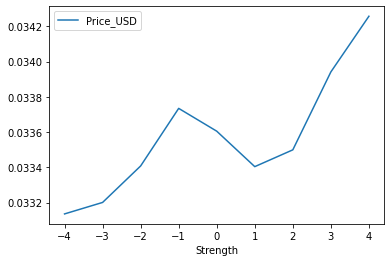

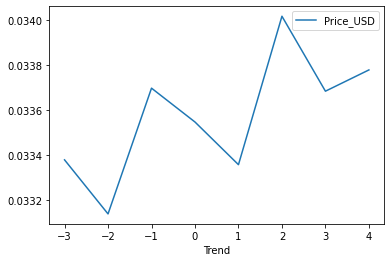

In [30]:
# 發現 Strenght 在 強度 4 的時候 RSI>=80 且 K>D，以我的程式邏輯來講，台幣價格相對高，建議賣出
tec_df[["Price_USD","Strength"]].groupby(by = "Strength").mean().plot()
# Trend 發現與價格呈正相關的關係，但介於-1~1之間有雜訊出現先不管他，在>=2時代表價格
tec_df[["Price_USD","Trend"]].groupby(by = "Trend").mean().plot()

<AxesSubplot:xlabel='Trend'>

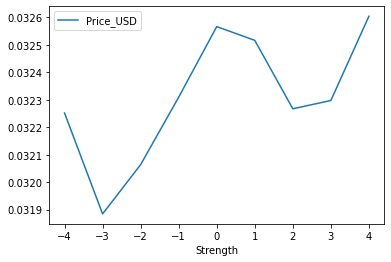

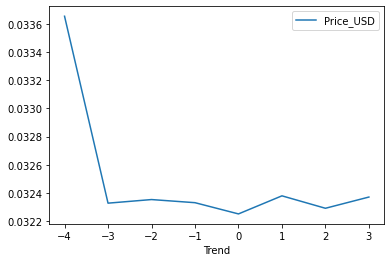

In [31]:
# 發現 Strenght 在 強度 4 的時候 RSI>=80 且 K>D，以我的程式邏輯來講，台幣價格相對高，建議賣出
tec_df_1[["Price_USD","Strength"]].groupby(by = "Strength").mean().plot()
# Trend 發現與價格呈正相關的關係，但介於-1~1之間有雜訊出現先不管他，在>=2時代表價格
tec_df_1[["Price_USD","Trend"]].groupby(by = "Trend").mean().plot()

In [32]:
tec_df[["Price_USD"]].shape

(1263, 1)

In [33]:
buy_sell = np.zeros(tec_df[["Price_USD"]].shape)
sell = np.zeros(tec_df[["Price_USD"]].shape)

#return dataframe
def buy_sell(df):
    buy_sell = np.zeros(tec_df[["Price_USD"]].shape)
    for index, trend in enumerate(tec_df["Trend"].tolist()):
        if trend == 4:
            buy_sell[index] = -3000000
        elif trend == 3:
            buy_sell[index] = -2000000
        elif trend == 2:
            buy_sell[index] = -1000000
        elif trend == -2:
            buy_sell[index] = 1000000
        elif trend == -3:
            buy_sell[index] = 2000000
        elif trend == -4:
            buy_sell[index] = 3000000
            
    for index, strength in enumerate(tec_df["Strength"].tolist()):
        if strength == 4:
            buy_sell[index] = -3000000
        elif strength == 3:
            buy_sell[index] = -2000000
        elif strength == 2:
            buy_sell[index] = -1000000
        elif strength == -2:
            buy_sell[index] = 1000000
        elif strength == -3:
            buy_sell[index] = 2000000
        elif strength == -4:
            buy_sell[index] = 3000000
    df["buy_sell"] = buy_sell 
    return df
    
    
output_df = buy_sell(tec_df)

In [34]:
output_df.describe()
output_df[["buy_sell"]].value_counts()

buy_sell  
 0.0          439
-1000000.0    243
 1000000.0    210
-2000000.0    187
 2000000.0    145
-3000000.0     24
 3000000.0     15
dtype: int64

In [35]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   RSI        1263 non-null   int64  
 1   KD         1263 non-null   int64  
 2   MA         1263 non-null   int64  
 3   MACD       1263 non-null   int64  
 4   Strength   1263 non-null   int64  
 5   Trend      1263 non-null   int64  
 6   Price_USD  1263 non-null   float64
 7   buy_sell   1263 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 79.1 KB


In [36]:
# hold_foreign = list(map(lambda x, y: x*y, output_df["buy_sell"].tolist(), output_df["Price_USD"].tolist()))
# cost_tw = sum(output_df["buy_sell"].tolist())
# hold_tw = sum(hold_foreign) / output_df["Price_USD"].tolist()[-1]

# print("Total profits:" + str(hold_tw - cost_tw))
# # hold_foreign = sum(hold_tw) * output_df["Price_USD"].tolist()[-1]
# # hold_foreign - cost

In [37]:
def backtest(df, days):
    profits = 0
    for index, price  in enumerate(df["Price_USD"].tolist()):
        if index < len(df["Price_USD"].tolist()) - days:
                profits += ( df["buy_sell"].tolist()[index] / price *
                            df["Price_USD"].tolist()[index+days]) - df["buy_sell"].tolist()[index]
    return profits

print("Total profits:" + str(round(backtest(output_df,7),0)))

Total profits:110376.0


In [39]:
len(output_df["Price_USD"].tolist())

1263

In [48]:
df

,Date,Price_USD,Open_USD,High_USD,Low_USD,USD_Change %
0,2000/1/3,0.031883,0.031883,0.031852,0.031903,NaN
1,2000/1/4,0.032760,0.032180,0.032118,0.032760,0.027518
2,2000/1/5,0.032547,0.032760,0.032441,0.032760,-0.006509
3,2000/1/6,0.032489,0.032489,0.031526,0.032499,-0.001787
4,2000/1/7,0.032494,0.032347,0.032305,0.032494,0.000162
...,...,...,...,...,...,...
5692,2021/10/25,0.035878,0.035904,0.035817,0.035926,-0.000179
5693,2021/10/26,0.035987,0.035872,0.035837,0.036054,0.003023
5694,2021/10/27,0.035973,0.035966,0.035862,0.036056,-0.000396
5695,2021/10/28,0.035985,0.035953,0.035871,0.036063,0.000360


In [50]:
df["Price_USD"].tolist()[1+2]

0.03248862897985705

In [39]:
output_df.to_csv("for_ta.csv")

In [38]:
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
import scipy.optimize as opt
def backtest(input_df, initial_guess):
    linear_constraint = LinearConstraint([1],[0],[len(input_df["Price_USD"].tolist())])
#     bounds = Bounds(0, len(input_df["Price_USD"].tolist()))
    def optimize(guess):
        print(int(guess.item()))
        profits = 0
        for index, price  in enumerate(input_df["Price_USD"].tolist()):
            if index < len(input_df["Price_USD"].tolist()) - int(guess.item()):
                    profits -= (price * input_df["buy_sell"].tolist()[index] /
                                input_df["Price_USD"].tolist()[index+int(guess.item())]) - input_df["buy_sell"].tolist()[index]
        return profits

    res = opt.minimize(fun = optimize, x0=initial_guess, method="trust-constr" , constraints = [linear_constraint])
    return res.x

print("Total profits:" + str(backtest(output_df, 13)))

13
13
13
13
Total profits:[13.00676028]


C:\Users\Administrator\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


### Scikit-Learn

In [84]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5697 entries, 2000-01-03 to 2021-10-29
Data columns (total 65 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price_USD     5697 non-null   float64
 1   Open_USD      5697 non-null   float64
 2   High_USD      5697 non-null   float64
 3   Low_USD       5697 non-null   float64
 4   USD_Change %  5696 non-null   float64
 5   Price_CNY     5697 non-null   float64
 6   Open_CNY      5697 non-null   float64
 7   High_CNY      5697 non-null   float64
 8   Low_CNY       5697 non-null   float64
 9   CNY_Change %  5696 non-null   float64
 10  Price_JPY     5697 non-null   float64
 11  Open_JPY      5697 non-null   float64
 12  High_JPY      5697 non-null   float64
 13  Low_JPY       5697 non-null   float64
 14  JPY_Change %  5696 non-null   float64
 15  Price_EUR     5697 non-null   float64
 16  Open_EUR      5697 non-null   float64
 17  High_EUR      5697 non-null   float64
 18  Low_EUR   

In [85]:
# 熟悉使用DataFame的方式
print(df3.iloc[0,0])
print(df3.loc["2000-01-03","Price_USD"])
print(df3.columns.tolist().index("Price_USD"))

0.03188267176789415
0.03188267176789415
0


In [86]:
# 簡單前處理
df_USD = df3[["Price_USD","USD_Change %","RSI_7_USD","MA_5_USD","K_9_USD","D_9_USD","K>D_9_USD","macd_USD","macd_s_USD","macd_h_USD"]].fillna(0)
#先將30天多的資料做刪除 （有些為0，有些是fillna的，不太想用）
df_USD = df_USD.iloc[45:,:]
df_USD

,Price_USD,USD_Change %,RSI_7_USD,MA_5_USD,K_9_USD,D_9_USD,K>D_9_USD,macd_USD,macd_s_USD,macd_h_USD
Date,,,,,,,,,,
2000-03-06,0.032520,-0.002439,43.914827,0.032573,268.561256,206.239672,1,0.000019,0.000030,0.000011
2000-03-07,0.032573,0.001629,58.327110,0.032573,346.033237,252.837527,1,0.000019,0.000028,0.000010
2000-03-08,0.032563,-0.000326,47.618866,0.032566,180.607418,228.760824,0,0.000017,0.000026,0.000009
2000-03-09,0.032573,0.000326,43.580964,0.032566,53.607985,170.376545,0,0.000016,0.000024,0.000008
2000-03-10,0.032531,-0.001301,40.480405,0.032552,60.746790,133.833293,0,0.000012,0.000022,0.000009
...,...,...,...,...,...,...,...,...,...,...
2021-10-25,0.035878,-0.000179,70.857058,0.035884,12.053139,-110.126373,1,-0.000027,-0.000053,-0.000026
2021-10-26,0.035987,0.003023,92.816552,0.035903,80.728190,-46.508185,1,-0.000012,-0.000045,-0.000033
2021-10-27,0.035973,-0.000396,75.660013,0.035921,125.091236,10.691622,1,-0.000001,-0.000036,-0.000035


In [87]:
df_USD.columns

Index(['Price_USD', 'USD_Change %', 'RSI_7_USD', 'MA_5_USD', 'K_9_USD',
       'D_9_USD', 'K>D_9_USD', 'macd_USD', 'macd_s_USD', 'macd_h_USD'],
      dtype='object')

In [88]:
def price_up_down(df, symbol):
    up_downs = list(map(lambda x,y: 1 if y>x else 0 , df["Price_"+symbol].tolist()[:-1], df["Price_"+symbol].tolist()[1:]))
    up_downs.append(0)
    df["Up_down_"+symbol] = up_downs
    return df
    
df_USD = price_up_down(df_USD, "USD")
df_USD.head()

,Price_USD,USD_Change %,RSI_7_USD,MA_5_USD,K_9_USD,D_9_USD,K>D_9_USD,macd_USD,macd_s_USD,macd_h_USD,Up_down_USD
Date,,,,,,,,,,,
2000-03-06,0.032520,-0.002439,43.914827,0.032573,268.561256,206.239672,1,0.000019,0.000030,0.000011,1
2000-03-07,0.032573,0.001629,58.327110,0.032573,346.033237,252.837527,1,0.000019,0.000028,0.000010,0
2000-03-08,0.032563,-0.000326,47.618866,0.032566,180.607418,228.760824,0,0.000017,0.000026,0.000009,1
2000-03-09,0.032573,0.000326,43.580964,0.032566,53.607985,170.376545,0,0.000016,0.000024,0.000008,0
2000-03-10,0.032531,-0.001301,40.480405,0.032552,60.746790,133.833293,0,0.000012,0.000022,0.000009,1


In [89]:
df_USD.index[1]

Timestamp('2000-03-07 00:00:00')

In [90]:
from sklearn.preprocessing import StandardScaler
df_USD_scale = StandardScaler().fit_transform(df_USD[['USD_Change %', 'RSI_7_USD', 'MA_5_USD', 'K_9_USD',
       'D_9_USD', 'K>D_9_USD', 'macd_USD', 'macd_s_USD', 'macd_h_USD']])
df_USD_scale = pd.DataFrame(df_USD_scale, columns=['USD_Change %', 'RSI_7_USD', 'MA_5_USD', 'K_9_USD',
       'D_9_USD', 'K>D_9_USD', 'macd_USD', 'macd_s_USD', 'macd_h_USD'])
df_USD_scale["Date"] = df_USD.index
df_USD_scale["Price_USD"] = df_USD["Price_USD"].tolist()
df_USD_scale = price_up_down(df_USD_scale,"USD")
df_USD_scale = df_USD_scale.set_index("Date")

In [91]:
df_USD_scale = df_USD_scale.drop(["Price_USD"], axis=1)
x_train = df_USD_scale.loc["2000":"2016"].drop(["Up_down_USD"], axis=1)
y_train = df_USD_scale.loc["2000":"2016"][["Up_down_USD"]]
x_test = df_USD_scale.loc["2017":"2021"].drop(["Up_down_USD"], axis=1)
y_test = df_USD_scale.loc["2017":"2021"][["Up_down_USD"]]

In [92]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(x_train, y_train)
pred = model.predict(x_test)

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [93]:
# 載入分類模型的衡量指標套件
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score
# 印出混淆矩陣
cm = confusion_matrix(y_test, pred)
pd.DataFrame({'預測為0': cm[:,0], '預測為1': cm[:,1]}, index=['真實為0','真實為1']) 

,預測為0,預測為1
真實為0,598,45
真實為1,576,44


In [94]:
# 印出常見指標的分數
fpr, tpr, thresholds = roc_curve(y_test, pred) 
pd.DataFrame({'Accuracy': accuracy_score(y_test, pred), 'AUC': auc(fpr, tpr), 'Precision': precision_score(y_test, pred), 'Recall': recall_score(y_test, pred), 'F1': f1_score(y_test, pred), 'TPR': tpr[1], 'FNR': cm[1][0]/(cm[1][0]+cm[1][1])}, index=['value:'])

,Accuracy,AUC,Precision,Recall,F1,TPR,FNR
value:,0.508314,0.500492,0.494382,0.070968,0.124118,0.070968,0.929032


In [95]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression() 
model.fit(x_train, y_train)
pred = model.predict(x_test)

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [96]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score
# 印出常見指標的分數(由混淆矩陣衍生)
pd.DataFrame({'Accuracy': accuracy_score(y_test, pred), 'AUC': roc_auc_score(y_test, model.decision_function(x_test)), 'Precision': precision_score(y_test, pred), 'Recall': recall_score(y_test, pred), 'F1': f1_score(y_test, pred)}, index=['value'])

,Accuracy,AUC,Precision,Recall,F1
value,0.505938,0.523536,0.494444,0.287097,0.363265


In [97]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_test)

cm = confusion_matrix(y_test, pred)         # 混淆矩陣
fpr, tpr, thresholds = roc_curve(y_test, pred)    
pd.DataFrame({'Accuracy': accuracy_score(y_test, pred), 'AUC': auc(fpr, tpr), 'Precision': precision_score(y_test, pred), 'Recall': recall_score(y_test, pred), 'F1': f1_score(y_test, pred), 'TPR': tpr[1], 'FNR': cm[1][0]/(cm[1][0]+cm[1][1])}, index=['values:'])

<ipython-input-97-6db301e3aef8>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


,Accuracy,AUC,Precision,Recall,F1,TPR,FNR
values:,0.496437,0.493789,0.482143,0.348387,0.404494,0.348387,0.651613


In [98]:
import xgboost as xgb

model = xgb.XGBClassifier(objective="binary:logistic") # Binary classification
model.fit(x_train, y_train)
pred = model.predict(x_test)

fpr, tpr, thresholds = roc_curve(y_test, pred)    
pd.DataFrame({'Accuracy': accuracy_score(y_test, pred), 'AUC': auc(fpr, tpr), 'Precision': precision_score(y_test, pred), 'Recall': recall_score(y_test, pred), 'F1': f1_score(y_test, pred), 'TPR': tpr[1], 'FNR': cm[1][0]/(cm[1][0]+cm[1][1])}, index=['values:'])

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,Accuracy,AUC,Precision,Recall,F1,TPR,FNR
values:,0.501188,0.497272,0.486111,0.282258,0.357143,0.282258,0.651613


In [99]:
x_test["Price_USD"] = df_USD["Price_USD"].loc["2017":"2021"].tolist()
buy = list(map(lambda x: 1000000 if x==1 else -1000000,pred.tolist()))
# buy_sell = list(map(lambda x : -1 if x==0 else 0, buy))
x_test["buy_sell"] = list(map(lambda x: 1000000 if x==1 else 0,pred.tolist()))

In [100]:
price = df_USD.loc["2017":"2021"]["Price_USD"].tolist()

hold_tw = list(map(lambda x, y: x/y, buy, price))
cost_foreign = sum(buy)
hold_foreign_sum = sum(hold_tw) * price[-1]

print("Total profits:" + str(round(hold_foreign_sum- cost_foreign,2)))


Total profits:-31877075.7


In [101]:
# def backtest(df, days):
#     profits = 0
#     for index, price  in enumerate(df["Price_USD"].tolist()):
#         if index < len(df["Price_USD"].tolist()) - days:
#                 profits += (price * df["buy_sell"].tolist()[index] /
#                             df["Price_USD"].tolist()[index+days]) - df["buy_sell"].tolist()[index]
#     return profits
profit = []
for i in range(20):
    profit.append(round(backtest(x_test, i),0))
    print("Total profits:" + str(round(backtest(x_test, i),0)))
profit.index(max(profit))

Total profits:0.0
Total profits:16025.0
Total profits:26387.0
Total profits:54941.0
Total profits:47482.0
Total profits:48930.0
Total profits:172577.0
Total profits:196546.0
Total profits:196852.0
Total profits:235557.0
Total profits:275197.0
Total profits:350739.0
Total profits:413813.0
Total profits:464223.0
Total profits:466383.0
Total profits:529502.0
Total profits:600823.0
Total profits:672505.0
Total profits:756657.0
Total profits:764118.0
Total profits:817585.0
Total profits:878335.0
Total profits:921004.0
Total profits:971660.0
Total profits:1053319.0
Total profits:1106445.0
Total profits:1165686.0
Total profits:1225095.0
Total profits:1274616.0
Total profits:1269483.0
Total profits:1344605.0
Total profits:1403636.0
Total profits:1449905.0
Total profits:1496293.0
Total profits:1561218.0
Total profits:1605383.0
Total profits:1684154.0
Total profits:1714433.0
Total profits:1814979.0
Total profits:1850853.0
Total profits:1884551.0
Total profits:1892978.0
Total profits:1926344.0
To

Total profits:7514154.0
Total profits:7487012.0
Total profits:7412316.0
Total profits:7397488.0
Total profits:7367069.0
Total profits:7326661.0
Total profits:7305162.0
Total profits:7211011.0
Total profits:7139031.0
Total profits:7056729.0
Total profits:6974229.0
Total profits:6958456.0
Total profits:6919939.0
Total profits:6974410.0
Total profits:6930795.0
Total profits:6935890.0
Total profits:6892706.0
Total profits:6877999.0
Total profits:6818164.0
Total profits:6765136.0
Total profits:6774161.0
Total profits:6702683.0
Total profits:6569403.0
Total profits:6426694.0
Total profits:6445236.0
Total profits:6344593.0
Total profits:6297551.0
Total profits:6357470.0
Total profits:6382560.0
Total profits:6347199.0
Total profits:6388297.0
Total profits:6401375.0
Total profits:6286688.0
Total profits:6303028.0
Total profits:6331734.0
Total profits:6306740.0
Total profits:6273239.0
Total profits:6162210.0
Total profits:6170483.0
Total profits:6186086.0
Total profits:6138542.0
Total profits:61

263

In [102]:
x_test.to_csv("RandomForest_x_test.csv")

### 匯出CSV檔

In [51]:
df3.to_csv("TWD_processed.csv")